In [1]:
# import lib 
import torch
import GPy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
# import file
from FixedGP import FixedGP
from FixedOnlineGP import FixedOnlineGP, standardize_vector
import time

#### **Objective**: We want to measure how the inversion method with schur complement is faster than with cholesky and the complexity of this inversion. We will use the FixedOnlineGP class for GPs. 

#### Build the data 

In [ ]:
nb_it = 2000

# Création de la grille de points dans l'hypercube normalisé (0, 1) x (0, 1)
x_coords = np.linspace(0, 1, 10)
y_coords = np.linspace(0, 1, 10)
X_test_normed = np.array(np.meshgrid(x_coords, y_coords)).T.reshape(-1, 2)

# Génération de train_X en prenant nb_it points aléatoires avec remise dans X_test_normed
train_X_indices = np.random.choice(X_test_normed.shape[0], nb_it, replace=True)
train_X = X_test_normed[train_X_indices]

# Génération de valeurs aléatoires standardisées pour train_Y
train_Y = np.random.randn(nb_it).reshape(-1,1)
train_Y = standardize_vector(train_Y)

#### Simulate the online GPs

In [3]:
# rep = 1

# gp_dur = np.zeros((2, rep, nb_it))
# inv_dur = np.zeros((2, rep, nb_it))

# for r in range(rep):
#     gp1 = FixedOnlineGP(input_space=X_test_normed, NB_IT=nb_it, lengthscale=0.4, noise_std=10)
#     gp1.set_kernel()
#     gp2 = FixedOnlineGP(input_space=X_test_normed, NB_IT=nb_it, lengthscale=0.4, noise_std=10)
#     gp2.set_kernel()
#     for i in range(nb_it):

#         ## ----- 1st GP with Schur complement method ----- ##
#         tic_gp1 = time.perf_counter()
#         inv_dur1 = gp1.update(query_x = train_X[i], query_y = train_Y[i])
#         tac_up1 = time.perf_counter()
#         gp1.predict()
#         tac_gp1 = time.perf_counter()

#         ## ----- 2nd GP with Cholesky method ----- ##
#         inv_dur2 = gp2.update_no_schur(query_x = train_X[i], query_y = train_Y[i])
#         tac_up2 = time.perf_counter()
#         gp2.predict()
#         tac_gp2 = time.perf_counter()


#         gp_dur[0,r,i] = tac_gp1 - tic_gp1
#         gp_dur[1,r,i] = tac_gp2 - tac_gp1
#         inv_dur[0,r,i] = inv_dur1
#         inv_dur[1,r,i] = inv_dur2   

#         if (i + 1) % 100 == 0:
#             print(f"we have just done the {i+1} th it for the {r} th rep")  

In [ ]:
rep = 1

gp_dur = np.zeros((1, rep, nb_it))
inv_dur = np.zeros((1, rep, nb_it))

for r in range(rep):
    gp = FixedOnlineGP(input_space=X_test_normed, NB_IT=nb_it, lengthscale=0.4, noise_std=10)
    gp.set_kernel()
    for i in range(nb_it):

        ## ----- GP with Schur complement method ----- ##
        tic_gp1 = time.perf_counter()
        inv_dur1 = gp.update(query_x = train_X[i], query_y = train_Y[i])
        tac_up1 = time.perf_counter()
        gp.predict()
        tac_gp1 = time.perf_counter()

        gp_dur[0,r,i] = tac_gp1 - tic_gp1
        inv_dur[0,r,i] = inv_dur1  

        if (i + 1) % 100 == 0:
            print(f"we have just done the {i+1} th it for the {r} th rep")  

In [4]:
# np.savez("results_custom/gp_and_inv_dur_1rep_5000it_sch_and_cho.npz", 
#          gp_dur=gp_dur, 
#          inv_dur=inv_dur, 
#          description="gp_dur: array of shape (2, nb_rep=1, nb_it=5000) where gp_dur[0] is the durations of the gp with SCHUR and gp_dur[1] with CHOLESKY\inv_dur: idem but for the inversion of K duration"
#          )

In [5]:

data = np.load("results_custom/gp_and_inv_dur_1rep_5000it_sch_and_cho.npz")
print(data['description'])
gp_dur = data['gp_dur']
inv_dur = data['inv_dur']

gp_dur: array of shape (2, nb_rep=1, nb_it=5000) where gp_dur[0] is the durations of the gp with SCHUR and gp_dur[1] with CHOLESKY\inv_dur: idem but for the inversion of K duration


#### Post process

In [6]:
gp1_duration = np.mean(gp_dur[0], axis= 0)
gp2_duration = np.mean(gp_dur[1], axis= 0)

gp1_duration_std = np.std(gp_dur[0], axis= 0)
gp2_duration_std = np.std(gp_dur[1], axis= 0)

In [7]:
inv1_duration = np.mean(inv_dur[0], axis= 0)
inv2_duration = np.mean(inv_dur[1], axis= 0)

inv1_duration_std = np.std(inv_dur[0], axis= 0)
inv2_duration_std = np.std(inv_dur[1], axis= 0)

#### Plot

In [8]:
# x = np.arange(nb_it)

# plt.figure(figsize=(10, 6))

# plt.plot(x,gp2_duration, color='red', label='cholesky_gp')
# plt.fill_between(x,gp2_duration - gp2_duration_std, gp2_duration + gp2_duration_std, color='lightcoral', alpha=0.5)

# plt.plot(x,inv2_duration, color='purple', label='cholesky_inv')
# plt.fill_between(x,inv2_duration - inv2_duration_std, inv2_duration + inv2_duration_std, color='lavender', alpha=0.5)

# plt.plot(x,gp1_duration, color='blue', label='schur_gp')
# plt.fill_between(x,gp1_duration - gp1_duration_std, gp1_duration + gp1_duration_std, color='lightblue', alpha=0.5)

# plt.plot(x,inv1_duration, color='green', label='schur_inv')
# plt.fill_between(x,inv1_duration - inv1_duration_std, inv1_duration + inv1_duration_std, color='lightgreen', alpha=0.5)

# plt.xlabel('nb of queries')
# plt.ylabel('gp duration [s]')
# plt.legend()
# plt.grid()
# plt.show()

In [9]:
def mean_by_interval(vector, n):
    # Check that the vector has a length sufficient for the operation
    if len(vector) < n:
        raise ValueError("The vector length must be greater than or equal to n.")
        
    # Compute means for intervals of 10
    interval_means = [np.mean(vector[i:i+10]) for i in range(0, len(vector) - n)]
    
    return np.array(interval_means)

In [10]:
smooth_int = 20
gp1_duration_s = mean_by_interval(gp1_duration, smooth_int)
gp2_duration_s = mean_by_interval(gp2_duration, smooth_int)
inv1_duration_s = mean_by_interval(inv1_duration, smooth_int)
inv2_duration_s = mean_by_interval(inv2_duration, smooth_int)

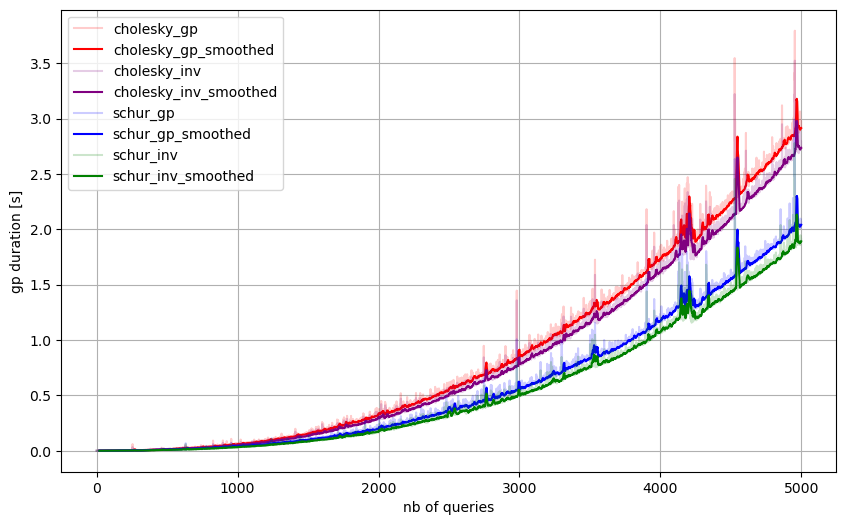

In [11]:
x = np.arange(nb_it)

plt.figure(figsize=(10, 6))

plt.plot(x,gp2_duration, color='red', label='cholesky_gp', alpha=0.2)
plt.plot(x[smooth_int:],gp2_duration_s, color='red', label='cholesky_gp_smoothed')

plt.plot(x,inv2_duration, color='purple', label='cholesky_inv', alpha=0.2)
plt.plot(x[smooth_int:],inv2_duration_s, color='purple', label='cholesky_inv_smoothed')

plt.plot(x,gp1_duration, color='blue', label='schur_gp', alpha=0.2)
plt.plot(x[smooth_int:],gp1_duration_s, color='blue', label='schur_gp_smoothed')

plt.plot(x,inv1_duration, color='green', label='schur_inv', alpha=0.2)
plt.plot(x[smooth_int:],inv1_duration_s, color='green', label='schur_inv_smoothed')

plt.xlabel('nb of queries')
plt.ylabel('gp duration [s]')
plt.legend()
plt.grid()
plt.show()

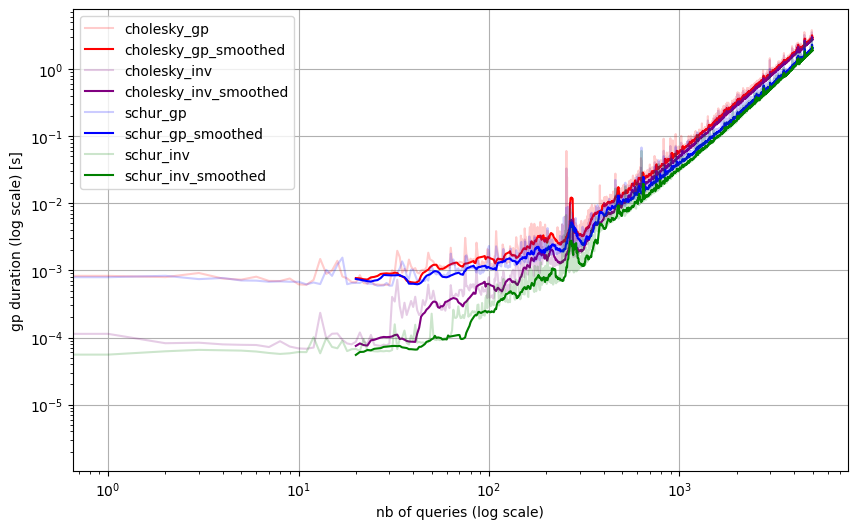

In [12]:
plt.figure(figsize=(10, 6))

plt.loglog(x,gp2_duration, color='red', label='cholesky_gp', alpha=0.2)
plt.loglog(x[smooth_int:],gp2_duration_s, color='red', label='cholesky_gp_smoothed')

plt.loglog(x,inv2_duration, color='purple', label='cholesky_inv', alpha=0.2)
plt.loglog(x[smooth_int:],inv2_duration_s, color='purple', label='cholesky_inv_smoothed')

plt.loglog(x,gp1_duration, color='blue', label='schur_gp', alpha=0.2)
plt.loglog(x[smooth_int:],gp1_duration_s, color='blue', label='schur_gp_smoothed')

plt.loglog(x,inv1_duration, color='green', label='schur_inv', alpha=0.2)
plt.loglog(x[smooth_int:],inv1_duration_s, color='green', label='schur_inv_smoothed')

plt.xlabel('nb of queries (log scale)')
plt.ylabel('gp duration (log scale) [s]')

plt.legend()
plt.grid()
plt.show()

Whith CHOLESKY : 
Calculated exponent (p): 2.48
Coefficient (alpha): 1.88e-09
Whith SCHUR : 
Calculated exponent (p): 2.55
Coefficient (alpha): 6.97e-10


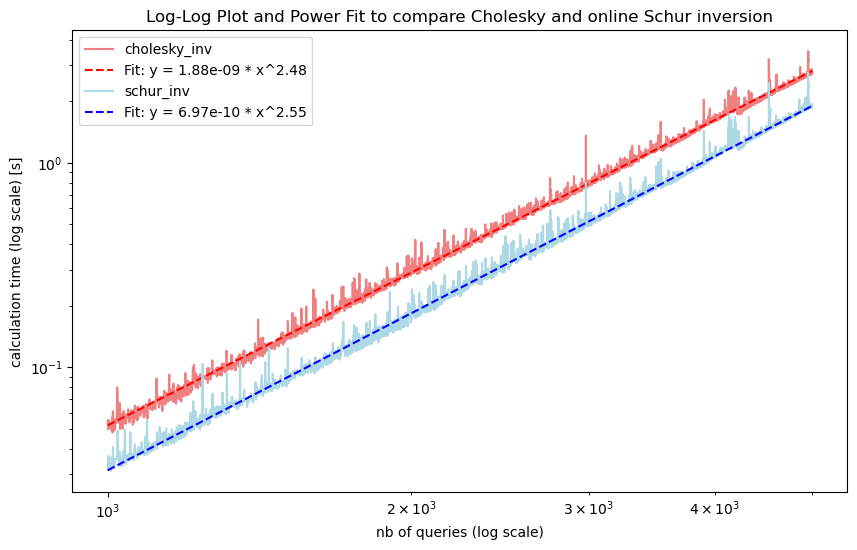

In [13]:
plt.figure(figsize=(10, 6))

## ----- Cholesky ----- ##

# Convert to log scale to fit a line and determine p
log_x = np.log(x[1000:])
log_y = np.log(inv2_duration[1000:])

# Perform linear regression on the log-log data
slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

# Display the result for the slope, which corresponds to the power p
print("Whith CHOLESKY : ")
print(f"Calculated exponent (p): {slope:.2f}")
print(f"Coefficient (alpha): {np.exp(intercept):.2e}")

# Plot the log-log graph
plt.loglog(x[1000:], inv2_duration[1000:], label='cholesky_inv', color='lightcoral')
plt.loglog(x[1000:], np.exp(intercept) * x[1000:]**slope, '--', label=f'Fit: y = {np.exp(intercept):.2e} * x^{slope:.2f}', color='red')



## ----- Schur ----- ##

# Convert to log scale to fit a line and determine p
log_x = np.log(x[1000:])
log_y = np.log(inv1_duration[1000:])

# Perform linear regression on the log-log data
slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

# Display the result for the slope, which corresponds to the power p
print("Whith SCHUR : ")
print(f"Calculated exponent (p): {slope:.2f}")
print(f"Coefficient (alpha): {np.exp(intercept):.2e}")

# Plot the log-log graph
plt.loglog(x[1000:], inv1_duration[1000:], label='schur_inv', color='lightblue')
plt.loglog(x[1000:], np.exp(intercept) * x[1000:]**slope, '--', label=f'Fit: y = {np.exp(intercept):.2e} * x^{slope:.2f}', color='blue')



# Add labels and legend
plt.xlabel('nb of queries (log scale)')
plt.ylabel('calculation time (log scale) [s]')
plt.title('Log-Log Plot and Power Fit to compare Cholesky and online Schur inversion')
plt.legend()
plt.show()